In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNEL = 3
EPOCH = 30

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
            "../PlantVillage",
            shuffle = True,
            image_size = (IMAGE_SIZE, IMAGE_SIZE),
            batch_size = BATCH_SIZE 
           )

Found 4438 files belonging to 7 classes.


In [4]:
class_names = dataset.class_names
class_names

['Apple__Black__Rot',
 'Apple__Healthy',
 'Apple__Scab',
 'Cedar__Apple__Rust',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy']

In [5]:
len(dataset)

139

In [6]:
# 68*BATCH_SIZE 

# 2176

In [7]:
# for image_batch, label_batch in dataset.take(1):
#     print(image_batch.shape)
#     print(label_batch.numpy())

# (32, 256, 256, 3)
# [1 0 0 0 0 1 1 0 0 1 1 1 1 2 1 0 0 1 0 1 0 0 1 0 1 1 1 1 0 0 0 0]

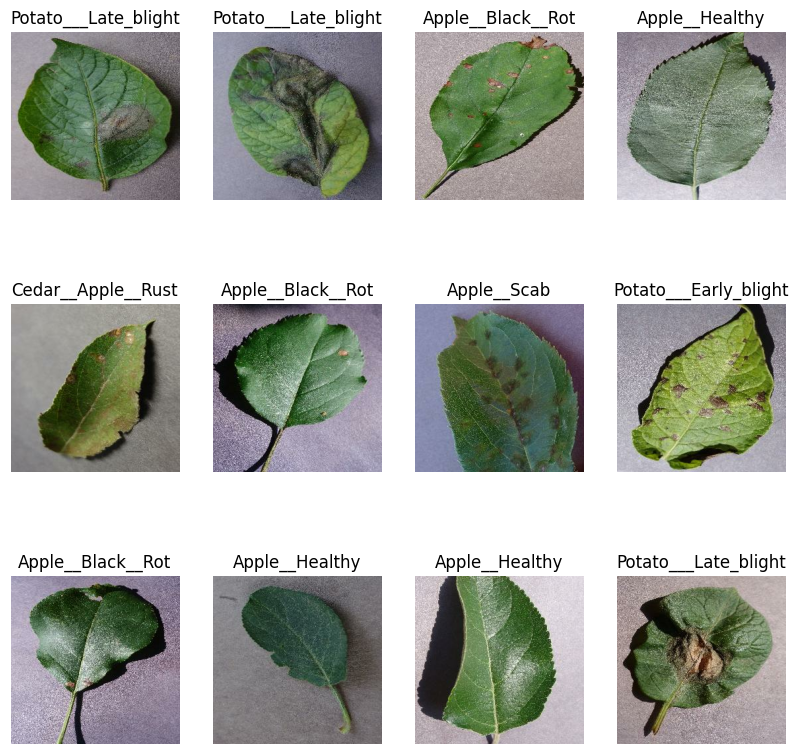

In [8]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [9]:
# 80% => Training
# 20% => 10% validation, 10% testing

In [10]:
train_size = 0.8
len(dataset) * train_size

111.2

In [11]:
train_ds = dataset.take(54) #raa[:54]
len(train_ds)

54

In [12]:
test_ds = dataset.skip(54)
len(test_ds)

85

In [13]:
val_size = 0.1
len(dataset) * val_size

13.9

In [14]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [15]:
test_ds = test_ds.skip(6)
len(test_ds)

79

In [16]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
        ds_size = len(ds)

        if shuffle:
            ds = ds.shuffle(shuffle_size, seed=12)
    
        train_size = int(train_split * ds_size)
        val_size = int(val_split * ds_size)

        train_ds = ds.take(train_size)
        val_ds = ds.skip(train_size).take(val_size)
        test_ds = ds.skip(train_size).skip(val_size)
    
        return train_ds, val_ds, test_ds

In [17]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [18]:
len(train_ds)

111

In [19]:
len(val_ds)

13

In [20]:
len(test_ds)

15

In [21]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [22]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [23]:
# Data Augmentation -> If image is flip/rotate
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizonatal_and_vertical"),
    layers.RandomRotation(0.2)
])

In [24]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNEL)
n_classes = 7

model = tf.keras.models.Sequential([
        resize_and_rescale,
        data_augmentation,

        layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2,2),

        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2,2),

        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2,2),

        layers.Conv2D(256, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.GlobalAveragePooling2D(),

        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(n_classes, activation='softmax')
])


c:\Users\nisar\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [25]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [26]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [27]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
    ]
)

Epoch 1/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 429s 4s/step - accuracy: 0.5415 - loss: 1.4804 - val_accuracy: 0.0481 - val_loss: 2.3680
Epoch 2/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 402s 4s/step - accuracy: 0.7964 - loss: 0.6366 - val_accuracy: 0.0769 - val_loss: 3.9356
Epoch 3/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 397s 4s/step - accuracy: 0.8393 - loss: 0.5004 - val_accuracy: 0.2428 - val_loss: 5.5324
Epoch 4/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 400s 4s/step - accuracy: 0.8606 - loss: 0.4205 - val_accuracy: 0.3269 - val_loss: 3.7419
Epoch 5/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 397s 4s/step - accuracy: 0.8735 - loss: 0.3935 - val_accuracy: 0.6442 - val_loss: 1.5193
Epoch 6/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 395s 4s/step - accuracy: 0.8907 - loss: 0.3304 - val_accuracy: 0.8197 - val_loss: 0.5412
Epoch 7/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 398s 4s/step - accuracy: 0.9039 - loss: 0.2912 - val_accuracy: 0.9159 - val_loss: 0.2579
Epoch 8/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 426s 4s/step - accuracy: 0.9149 - loss: 0.2767 - val_accu

In [28]:
scores = model.evaluate(test_ds)

15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 540ms/step - accuracy: 0.8734 - loss: 0.3767


13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 554ms/step


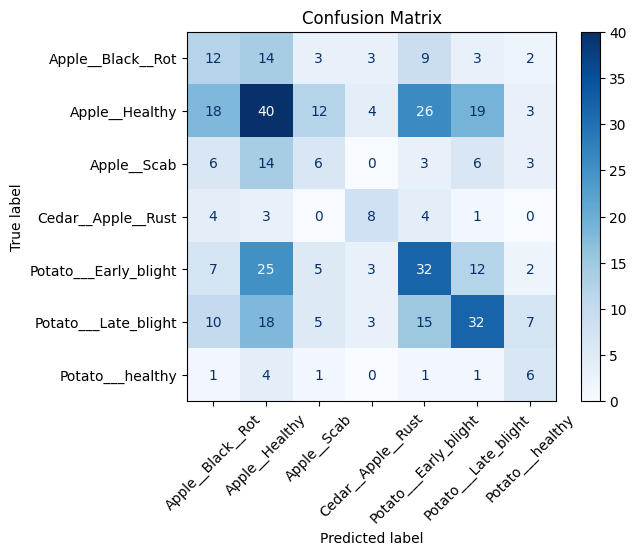

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

y_true = np.concatenate([y for x, y in val_ds], axis=0)
y_pred = model.predict(val_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(xticks_rotation=45, cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

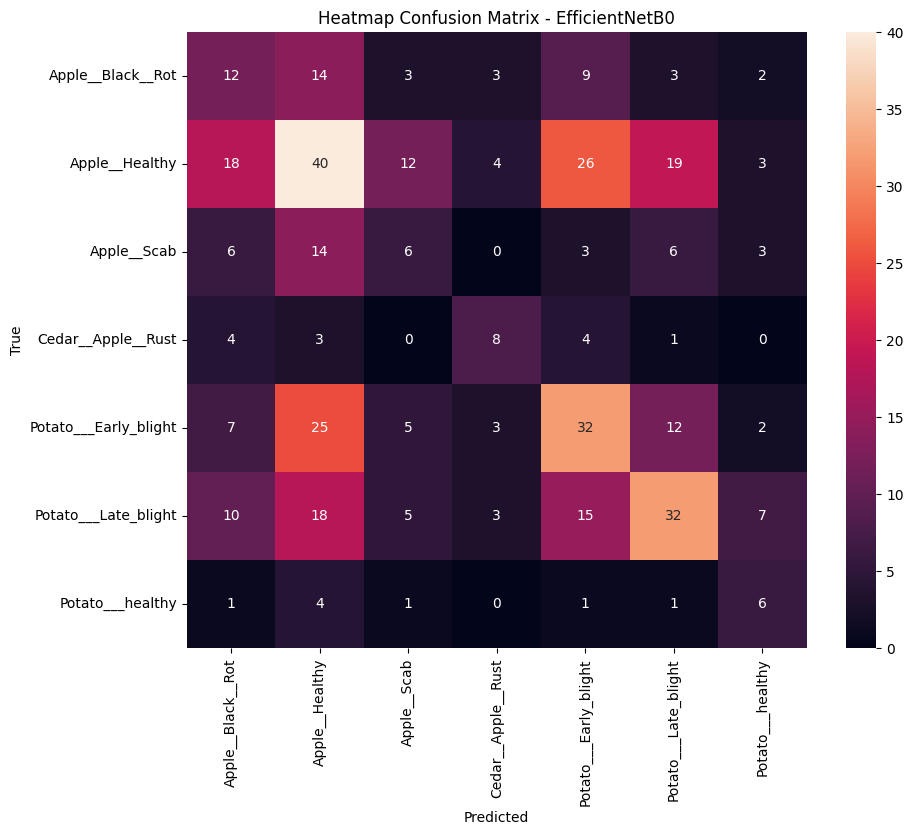

In [30]:
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', 
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Heatmap Confusion Matrix - EfficientNetB0")
plt.show()

In [31]:
scores

[0.34536609053611755, 0.8833333253860474]

In [32]:
history

In [33]:
history.params

{'verbose': 'auto', 'epochs': 30, 'steps': 111}

In [34]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

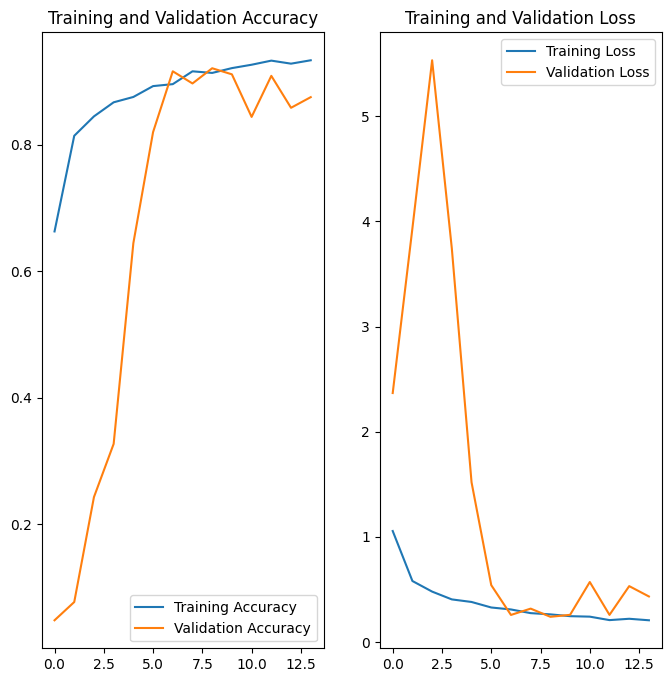

In [37]:
epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


First image to predict


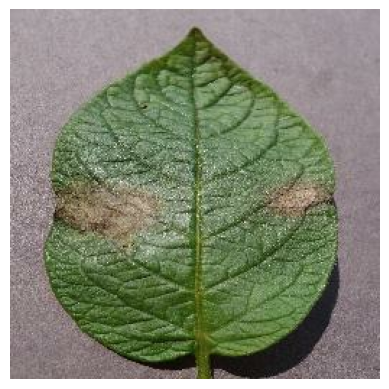

Actual Label :  Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted Label :  Potato___Late_blight


In [38]:
import numpy as np

# Take one batch from the test dataset
for image_batch, label_batch in test_ds.take(1):
    # Get the first image and label in the batch
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = label_batch[0].numpy()

    # Display the image
    print("First image to predict")
    plt.imshow(first_image)
    plt.axis('off')  # hides axis
    plt.show()

    # Print the actual label
    print("Actual Label : ", class_names[first_label])
    
    # Predict the label for the entire batch
    batch_prediction = model.predict(image_batch)
    
    # Get the predicted class of the first image
    predicted_class = np.argmax(batch_prediction[0])
    print("Predicted Label : ", class_names[predicted_class])

In [39]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img.numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array, verbose=0)
    
    predicted_index = np.argmax(predictions[0])
    predicted_class = class_names[predicted_index]
    
    confidence = round(100 * np.max(predictions[0]), 2)
    
    return predicted_class, confidence

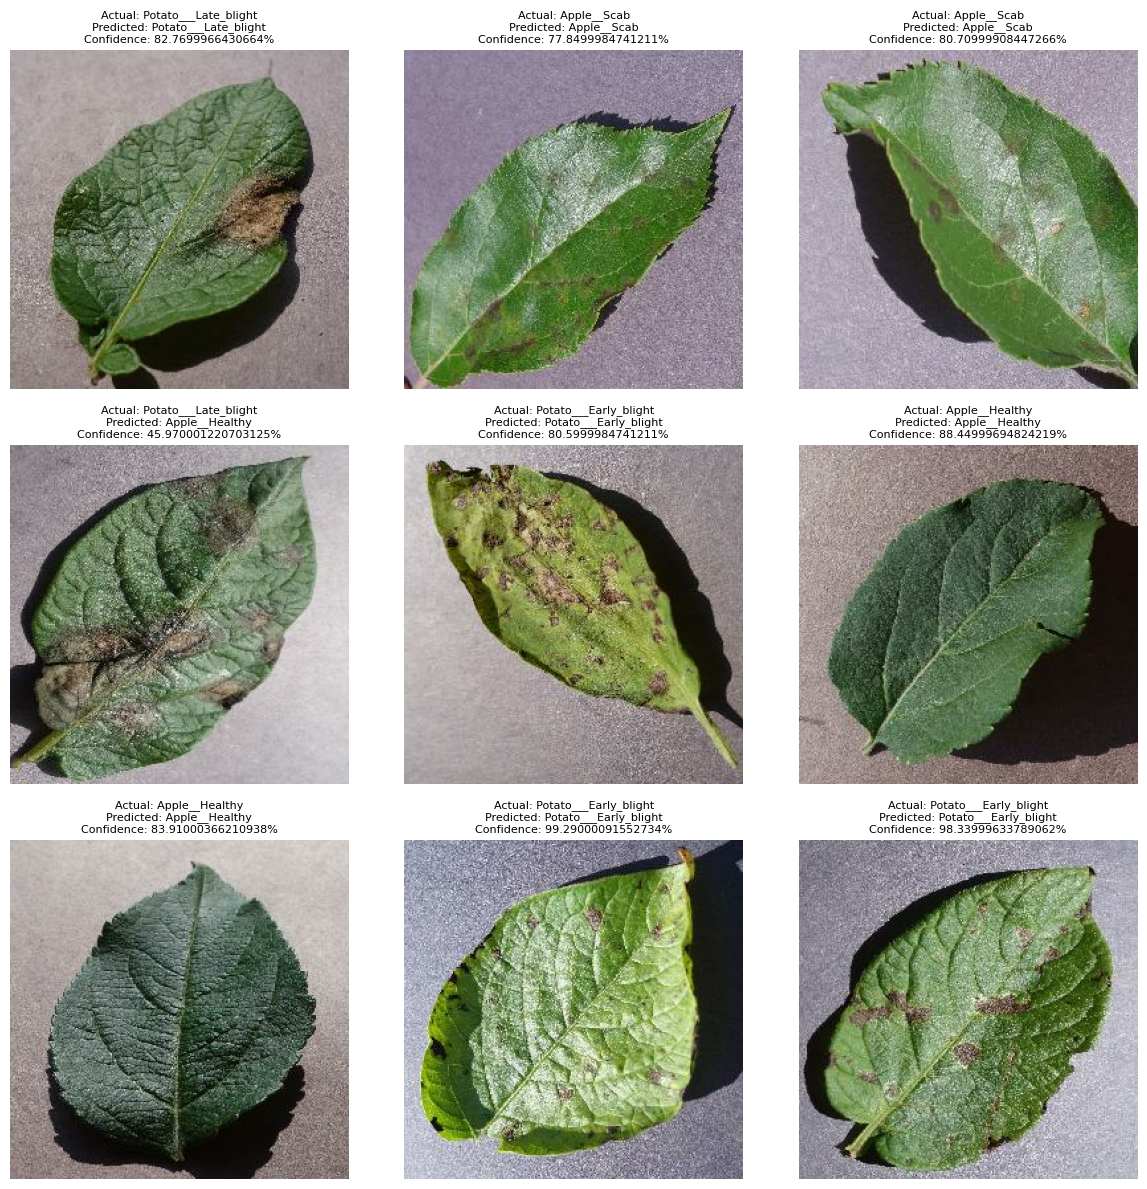

In [40]:
plt.figure(figsize=(12, 12))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))

        predicted_class, confidence = predict(model, images[i])
        actual_class = class_names[labels[i].numpy()]

        plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence}%", fontsize=8)
        plt.axis("off")
        
plt.tight_layout()
plt.show()

In [41]:
model.save("../Store-Model/model_seq.keras")
print("✅ Model Saved Successfully")

✅ Model Saved Successfully
